# Score dynamics

This notebook will guide you through (conditional) diffusion model training and inference for iteratively generating future molecular configurations based on an initial condition.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# I have a PyG version that prints a specific but otherwise harmless warning.
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

## Instantiate dataset

### Load data

The molecular trajecory data was converted to a dictionary-like data object in `.npz` file format with the following information:
- `symbols`: atomic symbols
- `numbers`: atomic numbers
- `x`: array of atomic positions
- `dx`: array of displacements relative to a future state over a predfined time interval 
- `v`: array of atomic velocities (currently unused)
- `dv`: array of velocity differences relative to a future state over a predfined time interval (currently unused)

In this repo only the mini-size version of the data is uploaded.

In [2]:
ala_dipep = np.load('./data/ala-dipep-dxdv-1ps-nvt-minisize.npz')

print(ala_dipep['symbols'])
print(ala_dipep['numbers'])
print(ala_dipep['x'].shape, ala_dipep['dx'].shape)

['CH' 'HH' 'HH' 'HH' 'C' 'O' 'N' 'H' 'CA' 'HA' 'CB' 'HB' 'HB' 'HB' 'C' 'O'
 'N' 'H' 'CH' 'HH' 'HH' 'HH']
[6 1 1 1 6 8 7 1 6 1 6 1 1 1 6 8 7 1 6 1 1 1]
(1000, 22, 3) (1000, 22, 3)


### Determine scaling factor

Scale the molecular system so that the quantity being denoised/generated, i.e., the displacement vector, is roughly on the same scale as a unit Gaussian distribution.

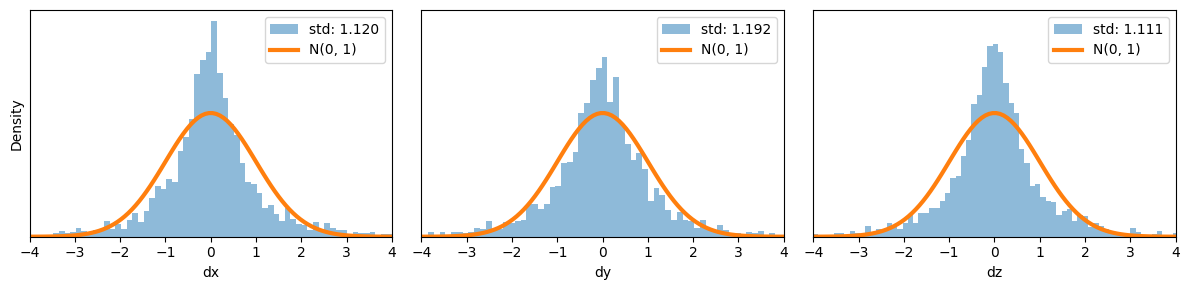

In [3]:
from scipy.stats import norm

SCALE = 2.0
mol = ala_dipep
dr = mol['dx']*SCALE

# Ignore hydrogens
# is_hydrogen = lambda e: e in ['H', 'HH', 'HA', 'HB']
# symbols = mol['symbols']
# mask = np.vectorize(is_hydrogen)(symbols)
# dr = dr[:, mask, :]

# Plot histograms of displacements
fig, axs = plt.subplots(figsize=(12, 3), nrows=1, ncols=3, sharex=True, sharey=True)
dr = dr.reshape(-1, 3)
dr_x = dr[::10, 0]
dr_y = dr[::10, 1]
dr_z = dr[::10, 2]
axs[0].hist(dr_x, bins=100, density=True, alpha=0.5, label=f'std: {dr_x.std():.3f}')
axs[1].hist(dr_y, bins=100, density=True, alpha=0.5, label=f'std: {dr_y.std():.3f}')
axs[2].hist(dr_z, bins=100, density=True, alpha=0.5, label=f'std: {dr_z.std():.3f}')

# Gaussian reference
u  = np.linspace(-4, 4, 100)
g  = norm.pdf(u)
for ax in axs: ax.plot(u, g, linewidth=3, label='N(0, 1)')

# Other plot settings
axs[0].set_xlabel('dx'); axs[1].set_xlabel('dy'); axs[2].set_xlabel('dz')
axs[0].legend(); axs[1].legend(); axs[2].legend()
axs[0].set_xlim(-4, 4)
axs[0].set_ylabel('Density')
axs[0].set_yticks([])
plt.tight_layout()
plt.show()

### Helper function for determining strong bonds

It may be beneficial to encode the distinction between strong bonds and weak bonds. This encoding is optional.

It is more robust to manually provide the strong bond indices as defined by the force field you use, but this notebook currently does not cover it.

In [4]:
from ase.neighborlist import primitive_neighbor_list
from graphite.nn.utils.ase import ase_radius_graph

# Predfined element-specific cutoffs for determining molecular bonds
mol_cutoffs = {
    ('H', 'C'): 1.74, ('H', 'N'): 1.65,  ('H', 'O'): 1.632,
    ('C', 'C'): 2.04, ('C', 'N'): 1.95,  ('C', 'O'): 1.932,
    ('N', 'N'): 1.86, ('N', 'O'): 1.842, ('O', 'O'): 1.824,
}

### Define dataset class

In [5]:
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import radius_graph
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial.transform import Rotation
from tqdm.notebook import tqdm

class MolTrajDataset(Dataset):
    def __init__(self, moltraj_list, cutoff, scale=1.0, ignore_Hs=False, track_strong_bonds=False):
        super().__init__()
        self.cutoff    = cutoff
        self.scale     = scale
        self.ignore_Hs = ignore_Hs

        # Determine all unique atom types for onehot encoding
        all_symbols = np.concatenate([mol['symbols'] for mol in moltraj_list])
        if ignore_Hs:
            is_hydrogen = lambda e: e in ['H', 'HH', 'HA', 'HB']
            mask        = np.vectorize(is_hydrogen)(symbols)
            all_symbols = all_symbols[mask]
        self.onehot_encoder = OneHotEncoder(sparse_output=False)
        self.onehot_encoder.fit(all_symbols.reshape(-1, 1))

        self.dataset = []
        for mol in moltraj_list:
            symbols = mol['symbols']
            numbers = mol['numbers']
            x, dx   = mol['x'], mol['dx']

            # Ignore hydroens?
            if ignore_Hs:
                is_hydrogen = lambda e: e in ['H', 'HH', 'HA', 'HB']
                mask        = np.vectorize(is_hydrogen)(symbols)
                symbols     = symbols[mask]
                numbers     = numbers[mask]
                x           = x[:, mask, :]
                dx          = dx[:, mask, :]

            # Encode atom type
            x_atm = self.onehot_encoder.transform(symbols.reshape(-1, 1))
            x_atm = torch.tensor(x_atm, dtype=torch.float)

            # Keep track of strong bonds?
            if track_strong_bonds:
                strong_bnd_index, _ = ase_radius_graph(torch.tensor(x[0]), mol_cutoffs, numbers)

            # Apply scaling
            x  *= scale
            dx *= scale
            
            # Instantiate dataset as a list of PyG Data objects
            for x_i, dx_i in tqdm(zip(x, dx), desc=f'Sampling {mol.fid.name}', total=len(x)):
                pos = torch.tensor(x_i,  dtype=torch.float)
                dx  = torch.tensor(dx_i, dtype=torch.float)
                i,j = radius_graph(pos, r=cutoff*scale)
                data = Data(
                    pos=pos, dx=dx, x_atm=x_atm.clone(), bnd_index=torch.stack([i,j]),
                    strong_bnd_index=strong_bnd_index.clone() if track_strong_bonds else None,
                )
                self.dataset.append(data)

    def len(self):
        return len(self.dataset)
    
    def get(self, idx):
        data = self.dataset[idx]
        data = self.random_rotate(data)
        return data

    def random_rotate(self, data):
        R = torch.tensor(Rotation.random().as_matrix(), dtype=torch.float, device=data.pos.device)
        data.pos @= R
        data.dx  @= R
        return data

### Set up dataloaders



In [6]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

PIN_MEMORY  = True
NUM_WORKERS = 4
BATCH_SIZE  = 256
CUTOFF      = 4.0

# Main dataset
dataset = MolTrajDataset([ala_dipep], cutoff=CUTOFF, scale=SCALE, ignore_Hs=False, track_strong_bonds=False)

# Train-validation split
train_set, valid_set = train_test_split(dataset, train_size=0.95, random_state=42)
print(f'Number of training graphs: {len(train_set)}')
print(f'Number of validation graphs: {len(valid_set)}')

# Move to data loaders
kwargs = {'batch_size': BATCH_SIZE, 'num_workers': NUM_WORKERS, 'pin_memory': PIN_MEMORY, 'follow_batch': ['pos']}
train_loader = DataLoader(train_set, shuffle=True,  **kwargs)
valid_loader = DataLoader(valid_set, shuffle=False, **kwargs)

Sampling ./data/ala-dipep-dxdv-1ps-nvt-minisize.npz:   0%|          | 0/1000 [00:00<?, ?it/s]

Number of training graphs: 950
Number of validation graphs: 50


## Training with PyTorch Lightning

### Model definitions

#### Version 1

Normal version.

In [7]:
from torch import nn
from graphite.nn.basis import GaussianRandomFourierFeatures
from graphite.nn import MLP

# Typing
from torch import Tensor
from typing import List, Optional, Tuple

class ScoreDynamicsModel(nn.Module):
    def __init__(self, encoder, processor, decoder):
        super().__init__()
        self.encoder   = encoder
        self.processor = processor
        self.decoder   = decoder
    
    def forward(self, x_atm:Tensor, bnd_index:Tensor, x_bnd:Tensor, x:Tensor, t:Tensor) -> Tensor:
        h_atm, h_bnd = self.encoder(x_atm, x_bnd, x, t, bnd_index)
        h_atm, h_bnd = self.processor(h_atm, bnd_index, h_bnd)
        return self.decoder(h_atm)

class ScoreDynamicsEncoder(nn.Module):
    def __init__(self, init_atm_dim, init_bnd_dim, dim=128):
        super().__init__()        
        self.init_atm_dim = init_atm_dim
        self.init_bnd_dim = init_bnd_dim
        self.dim          = dim
        
        self.embed_atm = nn.Sequential(MLP([init_atm_dim, dim, dim], act=nn.SiLU()), nn.LayerNorm(dim))
        self.embed_bnd = nn.Sequential(MLP([init_bnd_dim, dim, dim], act=nn.SiLU()), nn.LayerNorm(dim))
        self.embed_time = nn.Sequential(
            GaussianRandomFourierFeatures(dim, input_dim=1),
            MLP([dim, dim, dim], act=nn.SiLU()), nn.LayerNorm(dim),
        )
    
    def forward(self, x_atm:Tensor, x_bnd:Tensor, dx:Tensor, t:Tensor, bnd_index:Tensor) -> Tuple[Tensor, Tensor]:
        # Embed atoms (and add time embedding)
        h_atm = self.embed_atm(x_atm)
        h_atm += self.embed_time(t)

        # Embed bonds
        i = bnd_index[0]
        j = bnd_index[1]
        disp_bnd_vec = x_bnd[:, :3] + dx[j] - dx[i]
        disp_bnd_len = torch.linalg.norm(disp_bnd_vec, dim=-1, keepdim=True)
        h_bnd = self.embed_bnd(torch.hstack([x_bnd, disp_bnd_vec, disp_bnd_len]))
        
        return h_atm, h_bnd

#### Version 2

Distinction between strong vs. weak bonds is encoded.

In [ ]:
from torch import nn
from graphite.nn.basis import GaussianRandomFourierFeatures
from graphite.nn import MLP

# Typing
from torch import Tensor
from typing import List, Optional, Tuple

class ScoreDynamicsModel(nn.Module):
    def __init__(self, encoder, processor, decoder):
        super().__init__()
        self.encoder   = encoder
        self.processor = processor
        self.decoder   = decoder
    
    def forward(self, x_atm:Tensor, bnd_index:Tensor, x_bnd:Tensor, x:Tensor, t:Tensor, edge_mask:Tensor) -> Tensor:
        h_atm, h_bnd = self.encoder(x_atm, x_bnd, x, t, bnd_index, edge_mask)
        h_atm, h_bnd = self.processor(h_atm, bnd_index, h_bnd)
        return self.decoder(h_atm)

class ScoreDynamicsEncoder(nn.Module):
    def __init__(self, init_atm_dim, init_bnd_dim, dim=128):
        super().__init__()        
        self.init_atm_dim = init_atm_dim
        self.init_bnd_dim = init_bnd_dim
        self.dim          = dim
        
        self.embed_atm = nn.Sequential(MLP([init_atm_dim, dim, dim], act=nn.SiLU()), nn.LayerNorm(dim))
        self.embed_bnd = nn.Sequential(MLP([init_bnd_dim, dim, dim], act=nn.SiLU()), nn.LayerNorm(dim))
        self.embed_time = nn.Sequential(
            GaussianRandomFourierFeatures(dim, input_dim=1),
            MLP([dim, dim, dim], act=nn.SiLU()), nn.LayerNorm(dim),
        )
    
    def forward(self, x_atm:Tensor, x_bnd:Tensor, dx:Tensor, t:Tensor, bnd_index:Tensor, edge_mask:Tensor) -> Tuple[Tensor, Tensor]:
        # Embed atoms (and add time embedding)
        h_atm = self.embed_atm(x_atm)
        h_atm += self.embed_time(t)

        # Embed bonds
        i = bnd_index[0]
        j = bnd_index[1]
        disp_bnd_vec = x_bnd[:, :3] + dx[j] - dx[i]
        disp_bnd_len = torch.linalg.norm(disp_bnd_vec, dim=-1, keepdim=True)
        etype = torch.nn.functional.one_hot(edge_mask, num_classes=2)
        h_bnd = self.embed_bnd(torch.hstack([x_bnd, disp_bnd_vec, disp_bnd_len, etype]))
        
        return h_atm, h_bnd

### Helper functions and modules for training

In [8]:
from torch_geometric.nn import radius_graph
from graphite.diffusion import DPMSolverDiffuser
from graphite.nn import mask_edges

diffuser = DPMSolverDiffuser(schedule='linear')

def update_bond_features(data):
    i, j = data.bnd_index
    bond_vec = data.pos[j] - data.pos[i]
    bond_len = bond_vec.norm(dim=-1, keepdim=True)
    data.x_bnd = torch.hstack([bond_vec, bond_len])
    return data

def loss_fn(noise_net, batch):
    with torch.no_grad():
        lambdas = torch.empty(batch.num_graphs, 1, device=batch.pos.device).uniform_(diffuser.lambda_max, diffuser.lambda_min)
        t       = diffuser.t_lambda(lambdas)[batch.pos_batch]
        dx, eps = diffuser.forward_noise(batch.dx, t)
    pred_eps = noise_net(batch.x_atm, batch.bnd_index, batch.x_bnd, dx, t)
    return nn.functional.mse_loss(pred_eps, eps)

### Training instructions with `LightningModule`

In [9]:
from graphite.nn.models.mgn import Processor, Decoder
import lightning.pytorch as pl

class LitNoiseNet(pl.LightningModule):
    def __init__(self, num_species, num_convs, dim, out_dim, ema_decay=0.999, learn_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        # Core model
        self.model = ScoreDynamicsModel(
            encoder   = ScoreDynamicsEncoder(num_species, 4*2, dim),
            processor = Processor(num_convs, dim, dim),
            decoder   = Decoder(dim, out_dim),
        )
        
        # EMA model
        ema_avg = lambda avg_params, params, num_avg: ema_decay*avg_params + (1-ema_decay)*params
        self.ema_model = torch.optim.swa_utils.AveragedModel(self.model, avg_fn=ema_avg)

        # Training parameters
        self.learn_rate = learn_rate

    def training_step(self, batch, batch_idx):
        batch = update_bond_features(batch)
        loss = loss_fn(self.model, batch)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch.num_graphs)
        return loss

    def validation_step(self, batch, batch_idx):
        batch = update_bond_features(batch)
        loss = loss_fn(self.model, batch)
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True,  batch_size=batch.num_graphs)
        self.log('hp_metric',  loss, on_step=False, on_epoch=True, prog_bar=False, batch_size=batch.num_graphs)
    
    def configure_optimizers(self):
        return torch.optim.RAdam(self.model.parameters(), lr=self.learn_rate)

    def optimizer_step(self, *args, **kwargs):
        super().optimizer_step(*args, **kwargs)
        self.ema_model.update_parameters(self.model)

### Create a new model instance or load from a saved checkpoint

In [11]:
# New model instance
# noise_net = LitNoiseNet(num_species=10, num_convs=5, dim=200, out_dim=3)

# Load model from a saved checkpoint
noise_net = LitNoiseNet.load_from_checkpoint(
    './lightning_logs/ala-dipep-r4-S2-nvt-rand-tsize-240k/version_2/checkpoints/epoch=3404-step=800000.ckpt'
)

Lightning automatically upgraded your loaded checkpoint from v1.6.5 to v2.0.2. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint --file lightning_logs/ala-dipep-r4-S2-nvt-rand-tsize-240k/version_2/checkpoints/epoch=3404-step=800000.ckpt`


### Train!

Skip this section if you have loaded a trained model ready for rollouts.

- For *single-machine, single-GPU* training, run the code cell below.
- For *single-machine, multi-GPU* training, here is an example setup: `trainer = pl.Trainer(strategy='ddp', accelerator='gpu', devices=4, max_steps=MAX_STEPS, ...)`
- For *multi-machine, multi-GPU* training, specify the `num_nodes` argument to the `Trainer`. But besides that, there might be settings regarding the supercomputer/cluster setup (e.g., communication backend) that need to be addressed.

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger

MAX_STEPS = 600_000
RUN_NAME  = 'ala-dipep-test'
CKPT_PATH = None

# Specify a checkpoint file if you want to resume a training session 
# CKPT_PATH = './lightning_logs/ala-dipep-r4-S2-nvt-rand-tsize-240k/version_2/checkpoints/epoch=3404-step=800000.ckpt'

logger = TensorBoardLogger(save_dir='./lightning_logs/', name=RUN_NAME)
trainer = pl.Trainer(logger=logger, max_steps=MAX_STEPS)
trainer.fit(noise_net, train_loader, valid_loader, ckpt_path=CKPT_PATH)

# Roll-out from a given initial condition

### Helper functions

In [12]:
from ase.neighborlist import primitive_neighbor_list

def ala_dipep_chirality(pos):
    HA_CA = pos[8]  - pos[9]
    CA_CB = pos[10] - pos[8]
    CA_N  = pos[6]  - pos[8]
    return torch.cross(HA_CA, CA_CB).dot(CA_N)

def has_bad_structure(data, scale=1.0):
    s = scale

    # Check C-H bond lengths
    # i, j = data.CH_index; bnd_len = (data.pos[j]-data.pos[i]).norm(dim=1)
    # if torch.bitwise_or(bnd_len < 1.02*s, bnd_len > 1.16*s).any(): print(f'Step {n}: bad C-H bond length'); return True

    # Check C-C bond lengths
    # i, j = data.CC_index; bnd_len = (data.pos[j]-data.pos[i]).norm(dim=1)
    # if torch.bitwise_or(bnd_len < 1.38*s, bnd_len > 1.70*s).any(): print(f'Step {n}: bad C-C bond length'); return True

    # Check X-H bond lengths (X is any atom species)
    i, j = data.XH_index; bnd_len = (data.pos[j]-data.pos[i]).norm(dim=1)
    if torch.bitwise_or(bnd_len < 0.9*s, bnd_len > 1.16*s).any(): print(f'Step {n}: bad X-H bond length'); return True

    # Check CNO bond lengths (any bonds between {C, N, O})
    i, j = data.CNO_index; bnd_len = (data.pos[j]-data.pos[i]).norm(dim=1)
    if torch.bitwise_or(bnd_len < 1.1*s, bnd_len > 1.70*s).any(): print(f'Step {n}: bad CNO bond length'); return True

    # Check chirality of alanine dipeptide
    if ala_dipep_chirality(data.pos) < 0.0: print(f'Step {n} flipped chirality'); return True

    return False

def directed_XH_index(XH_index, numbers):
    mask = (numbers[XH_index[1]] == 1)
    return XH_index[:, mask]

def reset_XH_len(pos, XH_index, true_XH_len):
    X_idx, H_idx = XH_index
    XH_vec = pos[H_idx] - pos[X_idx]
    XH_len = XH_vec.norm(dim=1, keepdim=True)
    XH_vec *= (true_XH_len / XH_len)
    pos[H_idx] = pos[X_idx] + XH_vec

### Instantiate initial structure

In [13]:
# Read positions and atomic numbers
mol = ala_dipep
pos, symbols, numbers = mol['x'][0]*SCALE, mol['symbols'], mol['numbers']

# Instantiate PyG data
x_atm = dataset.onehot_encoder.transform(symbols.reshape(-1,1))
data = Data(
    pos   = torch.tensor(pos).float(),
    x_atm = torch.tensor(x_atm).float(),
).to('cuda')

# Keep track of strong-interaction bonds (e.g., C-C and C-H bonds)
pos = torch.tensor(pos)
data.XH_index, _  = ase_radius_graph(pos, cutoff={('H', 'C'): 1.74*SCALE, ('H', 'N'): 1.65*SCALE,  ('H', 'O'): 1.632*SCALE}, numbers=numbers)
data.CNO_index, _ = ase_radius_graph(pos, cutoff={('C', 'C'): 2.04*SCALE, ('C', 'N'): 1.95*SCALE,  ('C', 'O'): 1.932*SCALE}, numbers=numbers)
# data.CH_index, _  = ase_radius_graph(pos, cutoff={('H', 'C'): 1.74*SCALE}, numbers=numbers)
# data.CC_index, _  = ase_radius_graph(pos, cutoff={('C', 'C'): 2.04*SCALE}, numbers=numbers)

# For resetting X-H bond lengths during rollout
XH_index = directed_XH_index(data.XH_index, numbers).to('cuda')
X_idx, H_idx = XH_index
true_XH_len = (data.pos[H_idx] - data.pos[X_idx]).norm(dim=1, keepdim=True).to('cuda')

### Rollout!

In [14]:
# Prepare for rollout
NUM_STEPS = 100_000
rollout_pos = []
bad_pos = []
n = 0

# Torchscript optimization
model = torch.jit.script(noise_net.ema_model.module).to('cuda')

In [ ]:
import functools
from tqdm.notebook import tqdm

# Let's roll
with torch.no_grad():
    with tqdm(total=NUM_STEPS, desc='Rollout') as pbar:
        pbar.n = n; pbar.refresh()
        while n <= NUM_STEPS:
            # Update graph data
            data.bnd_index = radius_graph(data.pos, r=CUTOFF*SCALE, batch=data.batch)
            data = update_bond_features(data)

            # Catch bad structures
            if has_bad_structure(data, scale=SCALE):
                bad_pos.append(data.pos.cpu().numpy())
                del rollout_pos[-8:]
                n -= 8
                pbar.n = n; pbar.refresh()
                data.pos = rollout_pos[-1].clone()
                continue
            else:
                # Reset X-H bond lengths
                # reset_XH_len(data.pos, XH_index, true_XH_len)
                
                rollout_pos.append(data.pos.clone())
                n += 1
                pbar.update(1)

            # Generate displacements
            x_T = torch.randn_like(data.pos)
            noise_model = functools.partial(model, x_atm=data.x_atm, bnd_index=data.bnd_index, x_bnd=data.x_bnd)
            xs = diffuser.reverse_denoise(x_T, noise_model, diffuser.solver3, M=20)

            # Apply displacements
            dx = xs[-1]
            data.pos += dx

### Save the roll-out

In [26]:
import ase, ase.io

rollout_traj = [ase.Atoms(numbers=numbers, positions=pos/SCALE, cell=np.diag([30.]*3)) for pos in torch.stack(rollout_pos).cpu().numpy()]
for atoms in rollout_traj: atoms.center()
ase.io.write('./aka-dipep-rollout.extxyz', rollout_traj)